# Cluster Graph Belief Propagation

<a id='1'></a>
## 1. Table of Contents

* [1. Table of Contents](#1)
* [2. About this Notebook](#2)
* [3. Modeling Factors](#3)
    * [3.1 Variables](#3.1)
    * [3.2 Creating Tables](#3.2)
    * [3.3 Accessing Values](#3.3)
        * [3.3.1 Reading Variable Names](#3.3.1)
        * [3.3.2 Selecting Rows](#3.3.2)
        * [3.3.3 Access through Variable Assignment](#3.3.3)
        * [3.3.4 Reading Variable Assignment](#3.3.4)
    * [3.4 Factor Operations](#3.4)
        * [3.4.1 Factor Product](#3.4.1)
        * [3.4.2 Marginalization](#3.4.2)
* [4. Example Experimental Setup](#4)
    * [4.1 The Misconception Example](#4.1)
    * [4.2 Creating the Factors](#4.2)
* [5. CGBP Algorithm](#5)
    * [5.1 Preparations: Create Cluster Graph](#5.1)
    * [5.2 Initializations](#5.2)
    * [5.3 Simulation run](#5.3)
    * [5.4 Plotting](#5.4)

<a id='2'></a>
## 2. About this Notebook

This notebook is a demonstration of the cluster graph belief propagation algorithm, implemented in Python 3.5 **without any libraries for probability calculations** in order to not hide any important information processing. The [pandas library](http://pandas.pydata.org/) is used to generally model a tabular distribution and additional functions are added to provide computations that are relevant for probability theory.

The programming here was done without specifying any classes. It rather relies on python's basic functional programming abilities in order to emphasize the data transformations that are going on in the algorithm. Thus this notebook does not provide a library in any way, but rather a tutorial on how Cluster Graph Belief Propagation works in practice and how it could be implemented with basic python code (and pandas).

Most of the work will be preparations in order to actually work with factors, thus [Part 3. Modeling Factors](#3) is very big. If you are only interested in the actual experimental setup and simulation of the cluster graph belief propagation algorithm, go ahead and skip to [Part 4. Example Experimental Setup](#4) or [Part 5. CGBP Algorithm](#5).

Since we will need to call *reduce()* a couple of times for the functional approach and this is not included anymore by default in Python 3.5, we import it again.

In [1]:
from functools import reduce

<a id='3'></a>
## 3. Modeling Factors

The easiest way to represent factors for this example is as distribution tables over a set of variables. The values do not have to correspond to probabilities, since the algorithm works also for markov random fields. Below is an example of how such a table over the variables A and B could look like.

| a | b | $\phi$(A=a, B=b) |
|---|---|---          |
| $a_0$ | $b_0$ | 10  |
| $a_0$ | $b_1$ | 0.1 |
| $a_1$ | $b_0$ | 0.1 |
| $a_1$ | $b_1$ | 5   |

<a id='3.1'></a>
### 3.1 Variables

For this example, we use the following discrete (even binary in this case) random variables:

In [2]:
variables = {
    'A': [0, 1],
    'B': [0, 1],
    'C': [0, 1],
    'D': [0, 1]
}

<a id='3.2'></a>
### 3.2 Creating Tables
In order to create a couple of these tables and work with them, we make a function which creates an empty table over a set of variables. The additional parameters come in handy later. 

In [3]:
import pandas as pd

def make_empty_table(variables, subset_keys = None, fill_value = 0):
    """Creates an empty table-dataframe with rows for all variables.
    
        variables (dict): lists of values for every variable
        subset_keys: list of variables to include in the table
        fill_value: initialization value
        
        returns: empty table-dataframe with a row for every variable combination
    """
    
    # if list of subset is set empty: return table with only one entry
    if subset_keys == []:
        return pd.DataFrame(fill_value, index = [0], columns = ['value'])
    
    # filter variable subset
    if subset_keys:
        variables = {key: variables[key] for key in subset_keys}
    
    # create a new pandas dataframe
    # one row for every combination of variable values in the subset
    # (by taking the cartesian product)
    varnames = sorted(variables.keys())
    varvalues = [variables[var] for var in varnames]
    i = pd.MultiIndex.from_product(varvalues, names = varnames)
    df = pd.DataFrame(fill_value, index = i, columns = ['value']).reset_index()
    return df

The underlying usage of pandas dataframes allow for some complex use cases: Here are some examples.

Note: the numbers in the first column are the row indices that pandas generates automatically.

In [4]:
make_empty_table(variables, ['A', 'B'])

,A,B,value
0,0,0,0
1,0,1,0
2,1,0,0
3,1,1,0


In [5]:
make_empty_table(
    variables = {
        'A': ['a0', 'a1', 'a2'],
        'B': [0, 1],
        'C': [0, 1, 2]}, 
    subset_keys =['A', 'B'],
    fill_value = 42)

,A,B,value
0,a0,0,42
1,a0,1,42
2,a1,0,42
3,a1,1,42
4,a2,0,42
5,a2,1,42


In [6]:
make_empty_table(variables, [], 1)

,value
0,1


<a id='3.3'></a>
### 3.3 Accessing Values

Usual queries for distributions look like, e.g. **P(A=0, B=1)**, but pandas dataframes are not designed to allow for such descriptive access. In oder to make reading and writing values more intuitive, we need additional function wrappers.

<a id='3.3.1'></a>
#### 3.3.1 Reading Variable Names

The first step is to access the actual random variables in a table-dataframe:

In [7]:
def column_varnames(columns):
    """Extract the variable names from a columns object.
    
        columns: a dataframe-columns object
        
        returns: a list of variable names
    """
    
    return sorted([var for var in columns if var != 'value'])



def table_varnames(tab):
    """Extract the variable names from a table-dataframe.
    
        tab: a table-dataframe
        
        returns: a list of variable names
    """
    
    return column_varnames(tab.columns)

Here are some examples of the usage:

In [8]:
tmp_tab = make_empty_table(variables, ['A', 'B'])
tmp_tab

,A,B,value
0,0,0,0
1,0,1,0
2,1,0,0
3,1,1,0


In [9]:
table_varnames(tmp_tab)

['A', 'B']

In [10]:
tmp_tab.columns

Index(['A', 'B', 'value'], dtype='object')

In [11]:
column_varnames(tmp_tab.columns)

['A', 'B']

<a id='3.3.2'></a>
#### 3.3.2 Selecting Rows

The next step for accessing values is to get an actual reference on the values in the pandas dataframe. We want to access all rows, that contain a given assignment. So we first need to figure our for every row, if we actually want to include it. Since common variable assignments work as key-value-pair, we use a dictionary here.

In [12]:
def get_row_bools(tab, assignment):
    """For a given table and assignment, check which rows fit.
    
        tab: table-dataframe
        assignment (dict): variable assignment
        
        returns: table with booleans, indicating if the rows fit the assignment
    """
    
    # look at the table column-wise and check for every column, which rows to
    # select for the given assignment
    row_bools_each_column = [
        tab[v] == assignment[v]
        for v in table_varnames(tab)
        if v in assignment.keys()
    ]
    
    # reduce the list for all columns with AND, yields the booleans for the
    # complete assignment
    return reduce(lambda x,y: x & y, row_bools_each_column)

Again an example, of what the function returns for a given table:

In [13]:
tmp_tab

,A,B,value
0,0,0,0
1,0,1,0
2,1,0,0
3,1,1,0


In [14]:
get_row_bools(tmp_tab, assignment={'A': 0, 'B': 1})

0    False
1     True
2    False
3    False
dtype: bool

It is also possible to specify incomplete assignments, resulting in a set of rows being selected:

In [15]:
get_row_bools(tmp_tab, assignment={'A': 0})

0     True
1     True
2    False
3    False
Name: A, dtype: bool

<a id='3.3.3'></a>
#### 3.3.3 Access through Variable Assignment

Now we can define a function to write values for a given variable assignment. This works with the pandas lable-indexer **.loc()**.

In [16]:
def set_assignment(tab, assignment, value):
    """Write values in table for variable assignment.
        
        tab: the table-dataframe
        assignment (dict): the variable assignment
        value: the value to put into all selected rows
    """
    
    tab.loc[get_row_bools(tab, assignment), 'value'] = value

In [17]:
tmp_tab

,A,B,value
0,0,0,0
1,0,1,0
2,1,0,0
3,1,1,0


In [18]:
set_assignment(tmp_tab, {'A': 0, 'B': 1}, 42)
tmp_tab

,A,B,value
0,0,0,0
1,0,1,42
2,1,0,0
3,1,1,0


In [19]:
set_assignment(tmp_tab, {'A': 1}, -1)
tmp_tab

,A,B,value
0,0,0,0
1,0,1,42
2,1,0,-1
3,1,1,-1


<a id='3.3.4'></a>
#### 3.3.4 Reading Variable Assignment

For reading out the tables (e.g. for plotting) it will be important to read the variable assignments for the rows. Thus we need to define another function for this:

In [20]:
def get_assignment_for_row(table, row):
    """Returns the variable assignment for a row.
        
        table: the table-dataframe
        row: the row to access
        
        returns (dict): variable assignment of the row
    """
    
    return {v: table[v][row] for v in table_varnames(table)}

See an example:

In [21]:
get_assignment_for_row(tmp_tab, 2)

{'A': 1, 'B': 0}

<a id='3.4'></a>
### 3.4 Factor Operations

Now in order to use these tables to work with distributions, we need basic operators on distributions, namely the factor product between two factors and the option to marginalize a factor with respect to a set of variables.

<a id='3.4.1'></a>
#### 3.4.1 Factor Product

In [22]:
def multiply_tables(tab1, tab2):
    """Compute the factor product of two tables.
        
        tab1: first table
        tab2: second table
        
        returns: the factor product of tab1 and tab2
    """
    
    # check intersection and union of the variable sets
    varnames_intersect = column_varnames(tab1.columns & tab2.columns)
    varnames_union = column_varnames(tab1.columns | tab2.columns)
    
    # if the tables do not intersect, add additional merge key
    if not varnames_intersect:
        # copy to avoid side effects
        tab1 = tab1.copy()
        tab2 = tab2.copy()
        tab1['mergekey'] = 1
        tab2['mergekey'] = 1
        varnames_intersect = 'mergekey'
    
    # merge tables on intersection-set (or mergekey)
    tab3 = pd.merge(tab1, tab2, on = varnames_intersect)
    
    # compute value multiplication
    tab3['value'] = tab3['value_x'] * tab3['value_y']
    
    # select only the variables we need (union + 'Value')
    tab3 = tab3[varnames_union + ['value']]
    
    return tab3

Now again an example of how to use this... let's make two tables and multiply them:

In [23]:
tmp_tab1 = make_empty_table(variables, ['A', 'B'])
for (a, b, val) in [(0, 0, 30),
                    (0, 1, 5),
                    (1, 0, 1),
                    (1, 1, 10)]:
    set_assignment(tmp_tab1, {'A': a, 'B': b}, val)
tmp_tab1

,A,B,value
0,0,0,30
1,0,1,5
2,1,0,1
3,1,1,10


In [24]:
tmp_tab2 = make_empty_table(variables, ['A', 'C'])
for (a, c, val) in [(0, 0, 0.1),
                    (0, 1, 1),
                    (1, 0, 2),
                    (1, 1, 5)]:
    set_assignment(tmp_tab2, {'A': a, 'C': c}, val)
tmp_tab2

,A,C,value
0,0,0,0.1
1,0,1,1.0
2,1,0,2.0
3,1,1,5.0


In [25]:
tmp_tab_multi = multiply_tables(tmp_tab1, tmp_tab2)
tmp_tab_multi

,A,B,C,value
0,0,0,0,3.0
1,0,0,1,30.0
2,0,1,0,0.5
3,0,1,1,5.0
4,1,0,0,2.0
5,1,0,1,5.0
6,1,1,0,20.0
7,1,1,1,50.0


<a id='3.4.2'></a>
#### 3.4.2 Marginalization

In [26]:
def marginalize(tab, margin_vars):
    """Compute marginalization of table with respect to variable set.
    
        tab: table to marginalize
        margin_vars: variable set to marginlize over
        
        returns: marginalized table
    """
    
    # check which variables to keep
    vars_to_keep = [v for v in table_varnames(tab) if v not in margin_vars]
    
    # keep these variables and sum over the value for all other variables
    return (tab.groupby(vars_to_keep).sum())[['value']].reset_index()

Now we can marginalize over the multiplied table:

In [27]:
marginalize(tmp_tab_multi, ['C'])

,A,B,value
0,0,0,33.0
1,0,1,5.5
2,1,0,7.0
3,1,1,70.0


As you can see, this table does not correspond to *tmp_tab1* anymore, since it incorporates additional information that came from *tmp_tab2*.

<a id='4'></a>
## 4. Example Experimental Setup

Now that we have our basic tools for working with factor tables, we can create a small experimental setup to apply the cluster graph belief propagation algorithm on later.

<a id='4.1'></a>
### 4.1 The Misconception Example

The misconception example is a simple markov network, used for illustration purposes in

> Koller, Daphne, and Nir Friedman. *Probabilistic Graphical Models: Principles and Techniques.* Cambridge, MA: MIT, 2009. Print.

The graph looks like this:

<img src="markov.png" width="200px" />

And the specific factors are:

| a | b | $\phi_0$(A=a, B=b) |
|---|---|---|
| $a_0$ | $b_0$ | 30 |
| $a_0$ | $b_1$ | 5 |
| $a_1$ | $b_0$ | 1 |
| $a_1$ | $b_1$ | 10 |

| b | c | $\phi_1$(B=b, C=c) |
|---|---|---|
| $b_0$ | $c_0$ | 100 |
| $b_0$ | $c_1$ | 1 |
| $b_1$ | $c_0$ | 1 |
| $b_1$ | $c_1$ | 100 |

| c | d | $\phi_2$(C=c, D=d) |
|---|---|---|
| $c_0$ | $d_0$ | 1 |
| $c_0$ | $d_1$ | 100 |
| $c_1$ | $d_0$ | 100 |
| $c_1$ | $d_1$ | 1 |

| d | a | $\phi_3$(D=d, A=a) |
|---|---|---|
| $d_0$ | $a_0$ | 100 |
| $d_0$ | $a_1$ | 1 |
| $d_1$ | $a_0$ | 1 |
| $d_1$ | $a_1$ | 100 |

<a id='4.2'></a>
### 4.2 Creating the Factors

In order to simulate the cluster graph belief propagation algorithm for this example, we need to create the factors with our new tools:

In [28]:
# available variables and their possible values
variables = {
    'A': [0, 1],
    'B': [0, 1],
    'C': [0, 1],
    'D': [0, 1]
}

# initialize empty factors over their variables
phi0 = make_empty_table(variables, ['A', 'B'])
phi1 = make_empty_table(variables, ['B', 'C'])
phi2 = make_empty_table(variables, ['C', 'D'])
phi3 = make_empty_table(variables, ['D', 'A'])

# set values for all factors
for (a, b, val) in [(0, 0, 30),
                    (0, 1, 5),
                    (1, 0, 1),
                    (1, 1, 10)]:
    set_assignment(phi0, {'A': a, 'B': b}, val)
for (b, c, val) in [(0, 0, 100),
                    (0, 1, 1),
                    (1, 0, 1),
                    (1, 1, 100)]:
    set_assignment(phi1, {'B': b, 'C': c}, val)
for (c, d, val) in [(0, 0, 1),
                    (0, 1, 100),
                    (1, 0, 100),
                    (1, 1, 1)]:
    set_assignment(phi2, {'C': c, 'D': d}, val)
for (d, a, val) in [(0, 0, 100),
                    (0, 1, 1),
                    (1, 0, 1),
                    (1, 1, 100)]:
    set_assignment(phi3, {'D': d, 'A': a}, val)

# list of all factors
factors = [phi0, phi1, phi2, phi3]

Now e.g. factor $\phi_0$ looks like this:

In [29]:
phi0

,A,B,value
0,0,0,30
1,0,1,5
2,1,0,1
3,1,1,10


<a id='5.'></a>
## 5. CGBP Algorithm

Now we are going to implement and simulate the CGBP algorithm on the misconception example. First we need to initialize everything that we need for the algorithm to run.

<a id='5.1'></a>
### 5.1 Preparations: Create Cluster Graph

The most important part is to have an actual cluster graph. Since there are multiple possibilities for this setup, we need to specify explicitly, which factors belong to which cluster. We do this by referencing simply the indices of the factors:

In [30]:
# for every cluster: list of corresponding factor indices
clusters = [
    [0],
    [1],
    [2],
    [3]
]

This setup now corresponds to the following cluster graph with 4 clusters, each representing only one of the original factors:

<img src="cluster_graph.png" width="200px" />

The next step will be to store some properties of the cluster graph in easy-to-access data structures for the later algorithm. These properties can be extracted purely from the current setup.

In [31]:
# for every cluster: list of actual factors
cluster_factors = [
    [factors[f] for f in c]
    for c in clusters
]

Here we collected the actual factor tables for the clusters, not just the indices. Now we can e.g. extract all tables of cluster 0 (here this is only the first factor):

In [32]:
cluster_factors[0]

[   A  B  value
 0  0  0     30
 1  0  1      5
 2  1  0      1
 3  1  1     10]

In [33]:
# for every cluster: union set of all variables in contained factors
cluster_vars = [
    set(
        reduce(
            lambda x, y: x + y,
            [table_varnames(f) for f in c]
        )
    )
    for c in cluster_factors
]

Here we extract the list of variables present in every cluster. E.g. cluster 0 has factors about the variables A and B:

In [34]:
cluster_vars[0]

{'A', 'B'}

In [35]:
# list of all cluster edges (bidirectional)
# e.g. with indices (0, 1) for edge between clusters 0 and 1
cluster_edges = list({
    (c1, c2)
    for c1, var1 in enumerate(cluster_vars)
    for c2, var2 in enumerate(cluster_vars)
    if var1 & var2 and c1 != c2
})

Here we check, which clusters are connected through sharing a variable and create two edges (bidirectional!) for every connection. In our setup we have 4*2=8 edges:

In [36]:
print(cluster_edges)
print("# edges: {}".format(len(cluster_edges)))

[(0, 1), (1, 2), (3, 2), (3, 0), (2, 1), (2, 3), (1, 0), (0, 3)]
# edges: 8


In [37]:
# for every edge: sepset of variables
edge_sepsets = [
    cluster_vars[c1] & cluster_vars[c2]
    for (c1, c2) in cluster_edges
]

Now we can calculate the sepset for every edge. E.g. the sepset between clusters 0 and 1 is B:

In [38]:
for edge, sepset in zip(cluster_edges, edge_sepsets):
    if edge == (0,1):
        print(sepset)

{'B'}


In [39]:
# for every cluster: initial potential as sum of all contained factors
initial_potentials = [
    reduce(multiply_tables, [f for f in c])
    for c in cluster_factors
]

Also we can calculate the initial potentials, which is just factor multiplication of all factors in a cluster. Since we only have one factor in every cluster here, we just get the original factors.

In [40]:
initial_potentials[0]

,A,B,value
0,0,0,30
1,0,1,5
2,1,0,1
3,1,1,10


<a id='5.2'></a>
### 5.2 Initializations

Now we need to initialize two things before we can start: the messages for every edge and some instruction on which order to use for the message update.

The messages are usually initialized to 1. Which means a factor table over the sepset of the edge will all values being 1.

In [41]:
def initialize_messages():
    """Create initial messages, all with value = 1.
        
        returns: list of all initial messages
    """
    
    return [
        make_empty_table(variables, sepset, fill_value = 1)
        for sepset in edge_sepsets
    ]

E.g. for the edge between clusters 0 and 1, this is a table only over the variable B:

In [42]:
messages = initialize_messages()
for edge, msg in zip(cluster_edges, messages):
    if edge == (0,1):
        print(msg)

   B  value
0  0      1
1  1      1


For the message scheduling, we use just random selection here. This will not result in the best performance, but will suffice for demonstration purposes:

In [43]:
import random
def pick_edge_for_update(edges):
    """Select random edge for update.
    
        edges: list of edges to select from
        
        returns: index and edge, randomly selected
    """
    
    idx = random.randint(0, len(edges) - 1)
    return idx, edges[idx]


<a id='5.3'></a>
### 5.3 Simulation run

Now we can actually run a simulation of the CGBP algorithm. One important part for this to work in practice is the message normalization, where after every update, the message will be rescaled to sum to one. Otherwise numerical errors will appear very quickly. The message normalization is not actually documented in 
> Koller, Daphne, and Nir Friedman. *Probabilistic Graphical Models: Principles and Techniques.* Cambridge, MA: MIT, 2009. Print.

but widely used in practice.

Note that the actual execution of the following code block can take a couple of seconds.

In [44]:
# how many iterations should we simulate?
# in test runs, convergence took usually around 200-300 steps
iterations = 500

# collector list for storing the belief values over time
# the initial beliefs are the initial potentials
beliefs_coll = [initial_potentials]

# initialized messages
messages = initialize_messages()

for _ in range(iterations):

    # pick some edge/msg to update
    edge_idx, (i, j) = pick_edge_for_update(cluster_edges)
    msg = messages[edge_idx]

    # collect all incoming msgs that do not come from the edge to update
    incoming_msgs = [
        msg
        for (c1, c2), msg in zip(cluster_edges, messages)
        if c2 == i and c1 != j
    ]

    # multiply the tables from all incoming msgs
    initial_table = make_empty_table([], [], fill_value = 1)
    incoming_msgs_prod = reduce(multiply_tables, incoming_msgs, initial_table)

    # update potential
    incoming_with_potential = multiply_tables(initial_potentials[i],
                                              incoming_msgs_prod)

    # update message with marginalization over potential
    cluster_vars_without_sepset = cluster_vars[i] - edge_sepsets[edge_idx]
    messages[edge_idx] = marginalize(incoming_with_potential,
                                     cluster_vars_without_sepset)

    # message normalization
    msg_sum = messages[edge_idx]['value'].sum()
    messages[edge_idx]['value'] /= msg_sum

    # multiply all incoming messages for all clusters
    all_incoming_msgs_prod = [
        reduce(
            multiply_tables,
            [msg
             for (_, c2), msg in zip(cluster_edges, messages)
             if c2 == i]
        )
        for i, _ in enumerate(clusters)
    ]
    
    # update current beliefs
    current_beliefs = [
        multiply_tables(initial_potentials[i], all_incoming_msgs_prod[i])
        for i, _ in enumerate(clusters)
    ]
    
    # store beliefs over time
    beliefs_coll.append(current_beliefs)

<a id='5.4'></a>
### 5.4 Plotting

Now we have a list of all belief updates over time, which we can use for plotting the simulation results.

For the actual plotting it makes sense to convert the belief values in "probabilities", i.e. to normalize them. Note that these probabilities to not correspond to the real ones, but are the approximated beliefs for these probabilities.

In [45]:
def normalize_belief(belief):
    """Normalize a belief.
        
        belief: the belief to normalize
        
        returns: a normalized copy of the belief
    """
    
    # copying is important in order to not have any side effects
    b = belief.copy()
    s = b['value'].sum()
    b['value'] /= s
    return b

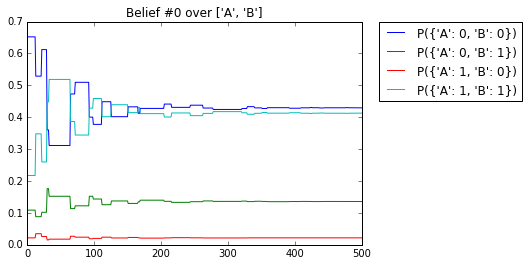

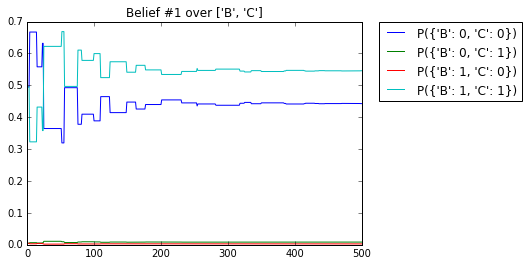

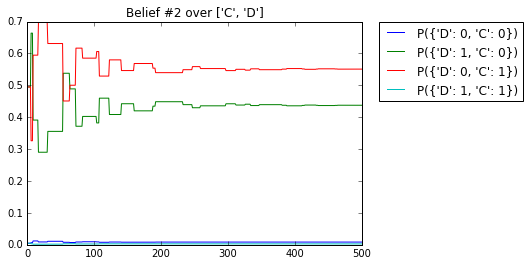

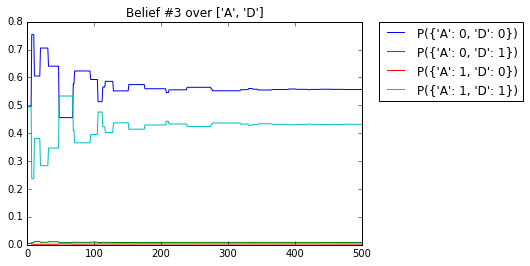

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

# make a figure for every belief (cluster)
for belief_i in range(len(clusters)):
    plt.figure()
    
    # extract and normalize only belief for current plot
    belief_over_time = [beliefs[belief_i] for beliefs in beliefs_coll]
    norm_belief = [normalize_belief(belief) for belief in belief_over_time]

    # plot all assignment values for current belief
    belief_rows = len(initial_potentials[belief_i])
    for row in range(belief_rows):
        
        # extract the raw values for this assignment
        line = [
            norm_belief[t]['value'][row]
            for t in range(len(norm_belief))
        ]
        
        # extract the assignment description (for labeling in the legend)
        assignment = {
            var: initial_potentials[belief_i][var][row]
            for var in table_varnames(initial_potentials[belief_i])
        }
        
        # plot the line
        plt.plot(line, label = "P({})".format(assignment))
    
    # make plot title and legend
    varnames = table_varnames(initial_potentials[belief_i])
    plt.title("Belief #{} over {}".format(belief_i, varnames))
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0.0)

plt.show()
